In [1]:
#pip install librosa

In [2]:
#pip install seaborn

In [3]:
# Import libraries 
import librosa
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, MaxPool1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2022-12-31 22:38:38.932380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 22:38:39.121484: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-31 22:38:39.886151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-31 22:38:39.886264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [4]:
Features = pd.read_csv('features.csv')
print(Features.shape)

(53352, 163)


In [5]:
# Fill NaN with 0
Features = Features.fillna(0)
print(Features.isna().any())


0         False
1         False
2         False
3         False
4         False
          ...  
158       False
159       False
160       False
161       False
labels    False
Length: 163, dtype: bool


In [6]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [7]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
np.array(Y).reshape(-1,1)
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype=object)]

In [8]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((42681, 162), (42681, 6), (10671, 162), (10671, 6))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.1, shuffle=True)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((38412, 162),
 (10671, 162),
 (4269, 162),
 (38412, 162),
 (10671, 162),
 (4269, 162))

In [10]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38412, 162), (38412, 6), (10671, 162), (10671, 6))

In [11]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((38412, 162, 1),
 (38412, 6),
 (10671, 162, 1),
 (10671, 6),
 (4269, 162, 1),
 (4269, 6))

In [12]:
x_train = np.squeeze(x_train, axis=2)
x_test = np.squeeze(x_test, axis=2)
x_val = np.squeeze(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((38412, 162), (38412, 6), (10671, 162), (10671, 6), (4269, 162), (4269, 6))

In [13]:
'''model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(512, kernel_size=5, strides=1,padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

#just add new layers
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(6, activation="softmax"))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()
'''

'model=Sequential()\nmodel.add(Conv1D(512, kernel_size=5, strides=1,padding="same", activation="relu",\n                        input_shape=(x_train.shape[1], 1)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(Conv1D(512, kernel_size=5, strides=1,padding="same", activation="relu"))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(Conv1D(256, kernel_size=5, strides=1, padding=\'same\', activation=\'relu\'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=5, strides = 2, padding = \'same\'))\n\nmodel.add(Conv1D(128, kernel_size=5, strides=1, padding=\'same\', activation=\'relu\'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=5, strides = 2, 

In [14]:
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(Dropout(0.25))


model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()


2022-12-31 22:38:48.797989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 22:39:05.614544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7425 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 512)          3072      
                                                                 
 batch_normalization (BatchN  (None, 162, 512)         2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           655616    
                                                                 
 batch_normalization_1 (Batc  (None, 81, 256)          1024      
 hNormalization)                                                 
                                                        

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.05,
    patience=20,
    verbose=1,
    restore_best_weights=True
)

In [16]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
callbacks = [early_stopping,rlrp]

In [17]:
earlystopping2 = EarlyStopping(monitor ="val_accuracy",min_delta=0.05,
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks2 = [learning_rate_reduction]

In [18]:
history=model.fit(x_train, y_train, batch_size=100, epochs=50, validation_data=(x_val, y_val),callbacks=callbacks2 )

Epoch 1/50
385/385 [==============================] - 77s 48ms/step - loss: 1.3156 - accuracy: 0.4756 - val_loss: 2.1071 - val_accuracy: 0.2870 - lr: 0.0010
Epoch 2/50
385/385 [==============================] - 17s 45ms/step - loss: 1.0858 - accuracy: 0.5550 - val_loss: 1.2754 - val_accuracy: 0.4849 - lr: 0.0010
Epoch 3/50
385/385 [==============================] - 18s 45ms/step - loss: 1.0124 - accuracy: 0.5817 - val_loss: 1.6364 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 4/50
385/385 [==============================] - 17s 45ms/step - loss: 0.9492 - accuracy: 0.6123 - val_loss: 1.1745 - val_accuracy: 0.5376 - lr: 0.0010
Epoch 5/50
385/385 [==============================] - 17s 45ms/step - loss: 0.9052 - accuracy: 0.6289 - val_loss: 1.1693 - val_accuracy: 0.5362 - lr: 0.0010
Epoch 6/50
385/385 [==============================] - 17s 45ms/step - loss: 0.8695

2022-12-31 22:39:22.845372: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-12-31 22:39:45.673088: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [19]:
# Save model and weights
'''model_name = '6_Emotion_Model_new_cnn_90_acc.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("Model Json/model_json_6_new_cnn_90_acc.json", "w") as json_file:
    json_file.write(model_json)]]'''

'model_name = \'6_Emotion_Model_new_cnn_90_acc.h5\'\nsave_dir = os.path.join(os.getcwd(), \'saved_models\')\n\nif not os.path.isdir(save_dir):\n    os.makedirs(save_dir)\nmodel_path = os.path.join(save_dir, model_name)\nmodel.save(model_path)\nprint(\'Save model and weights at %s \' % model_path)\n\n# Save the model to disk\nmodel_json = model.to_json()\nwith open("Model Json/model_json_6_new_cnn_90_acc.json", "w") as json_file:\n    json_file.write(model_json)]]'

In [20]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

334/334 [==============================] - 3s 7ms/step - loss: 0.7078 - accuracy: 0.8260
Accuracy of our model on test data :  82.59769678115845 %


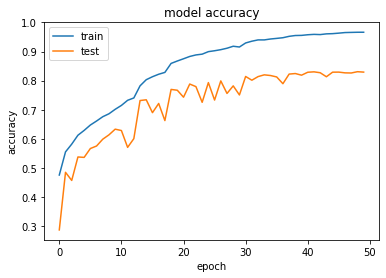

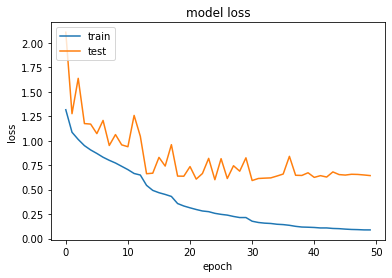

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# predicting on test data.
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

334/334 [==============================] - 2s 5ms/step


In [23]:
pred_test=model.predict(x_test)

334/334 [==============================] - 2s 5ms/step


In [24]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,happy,happy
1,angry,angry
2,happy,happy
3,surprise,surprise
4,fear,fear
5,surprise,surprise
6,neutral,neutral
7,sad,sad
8,happy,happy
9,sad,sad


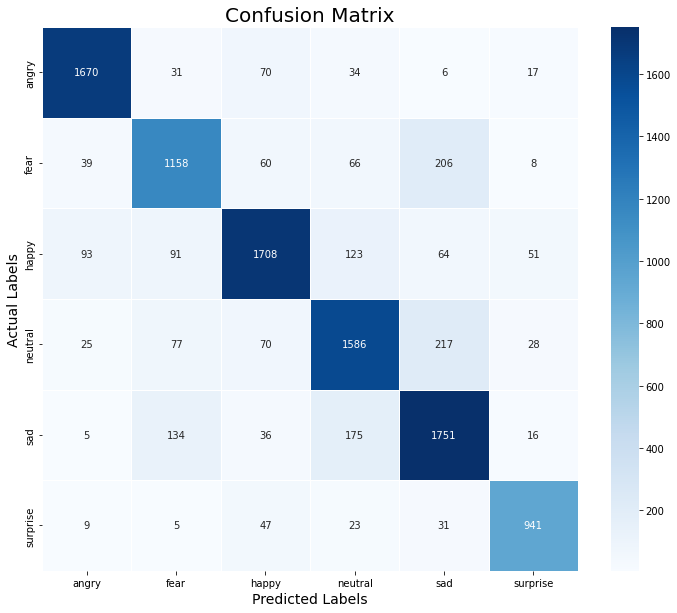

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.91      0.91      1828
        fear       0.77      0.75      0.76      1537
       happy       0.86      0.80      0.83      2130
     neutral       0.79      0.79      0.79      2003
         sad       0.77      0.83      0.80      2117
    surprise       0.89      0.89      0.89      1056

    accuracy                           0.83     10671
   macro avg       0.83      0.83      0.83     10671
weighted avg       0.83      0.83      0.83     10671

